Implementing sound waves in uniform density 1D gas with no body force

In [1]:
import numpy as np
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


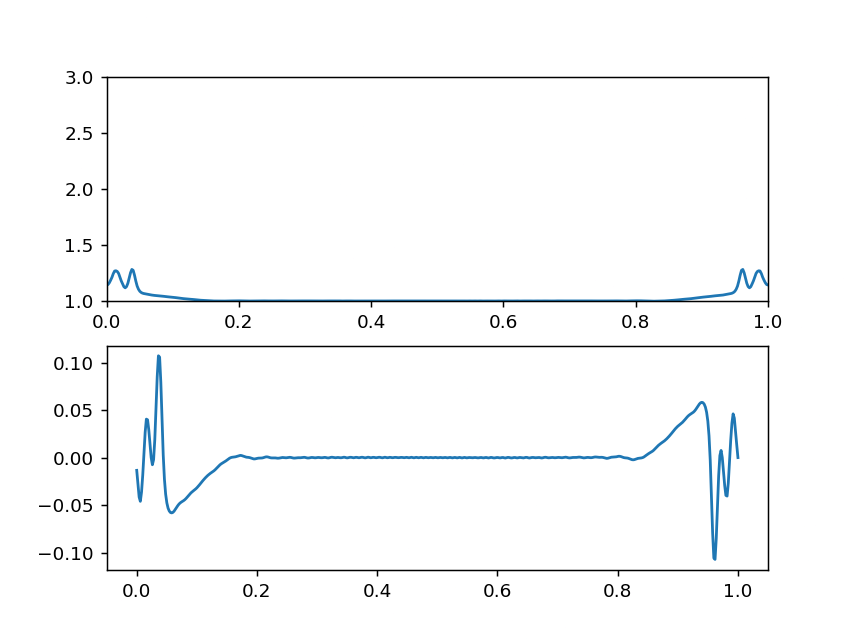

In [4]:
Nsteps = 1000
A = 1 # Perturbation amplitude
d = 0.01 # Perturbation width
N = 500 # Leftmost cell is 0, rightmost cell is N
Q = 0.7
Cs = 1
X = np.linspace(0, 1, N)
dx = X[1] - X[0]
dt = Q*dx/Cs

gaussian = A*np.exp(-(X-0.5)**2/ (2*d**2))
density = np.ones(X.shape)* (1+gaussian)
momentum = np.zeros(X.shape)

%matplotlib notebook
fig, axs = plt.subplots(2)
plt.ion()
fig.show()
fig.canvas.draw()

for i in range(Nsteps):
    # Update without source
    velocity_face = 1/2 * (momentum[:-1]/density[:-1] + momentum[1:]/density[1:])
    flux_dens_face = []
    flux_mom_face = []
    
    for i, veloc in enumerate(velocity_face):
        if veloc < 0:
            flux_dens_face.append(veloc * density[i+1])
            flux_mom_face.append(veloc * momentum[i+1])
        else:
            flux_dens_face.append(veloc * density[i])
            flux_mom_face.append(veloc * momentum[i])
    
    # Update including boundary conditions
    flux_dens_face = np.array(flux_dens_face)
    density[1:-1] -= dt/dx * (flux_dens_face[1:] - flux_dens_face[:-1])
    density[0] -= dt/dx * flux_dens_face[0]
    density[-1] += dt/dx * flux_dens_face[-1]
    flux_mom_face = np.array(flux_mom_face)
    momentum[1:-1] -= dt/dx * (flux_mom_face[1:] - flux_mom_face[:-1])
    momentum[0] -= dt/dx * flux_mom_face[0]
    momentum[-1] += dt/dx * flux_mom_face[-1]

    
    # Update with source
    velocity_face = 1/2 * (momentum[:-1]/density[:-1] + momentum[1:]/density[1:])
    flux_dens_face = []
    flux_mom_face = []
    
    for i, veloc in enumerate(velocity_face):
        if veloc < 0:
            flux_dens_face.append(veloc * density[i+1])
            flux_mom_face.append(veloc * momentum[i+1])
        else:
            flux_dens_face.append(veloc * density[i])
            flux_mom_face.append(veloc * momentum[i])
            
    momentum[1:-1] -= dt/dx * Cs**2/2  * (density[2:] - density[:-2])
    
    # Boundary conditions
    momentum[0] -= dt/dx/2 * (density[1] - density[0])
    momentum[-1] -= dt/dx/2 * (density[-1] - density[-2])

    mach = [speed / Cs for speed in velocity_face]
    mach = mach + [0]
    axs[0].clear()
    axs[1].clear()
    axs[0].set_xlim(0, 1)
    axs[0].set_ylim(1, 1+2*A)
    axs[0].plot(X, density)
    axs[1].plot(X, mach)
    fig.canvas.draw()
    plt.pause(0.001)